In [1]:
# Cell 1: Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Cell 2: Đọc file Samsung_clean.csv và xem cấu trúc dữ liệu
df = pd.read_csv('Samsung_clean.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

print(df.head())
print("\nCác cột trong dataset:", df.columns.tolist())


             Open   High    Low  Close    Adj Close    Volume
Date                                                         
2010-01-04  16060  16180  16000  16180  11978.36523  11950800
2010-01-05  16520  16580  16300  16440  12170.84668  27925850
2010-01-06  16580  16820  16520  16820  12452.17090  22948850
2010-01-07  16820  16820  16260  16260  12037.59082  22107950
2010-01-08  16400  16420  16120  16420  12156.04102  14777550

Các cột trong dataset: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [3]:
# Cell 3: Chọn cột 'Close' và chuẩn hóa với MinMaxScaler
data = df[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

print("Dữ liệu sau khi scale:\n", scaled_data[:5])


Dữ liệu sau khi scale:
 [[0.02918552]
 [0.0321267 ]
 [0.03642534]
 [0.0300905 ]
 [0.03190045]]


In [4]:
# Cell 4: Chia dữ liệu theo tỷ lệ 60/20/20
train_size = int(len(scaled_data) * 0.6)
val_size = int(len(scaled_data) * 0.2)
test_size = len(scaled_data) - train_size - val_size

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + val_size]
test_data = scaled_data[train_size + val_size:]

print(f"Train: {len(train_data)}, Validate: {len(val_data)}, Test: {len(test_data)}")


Train: 2335, Validate: 778, Test: 779


In [5]:
# Cell 5: Hàm tạo tập dữ liệu có dạng (X, y) cho RNN
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)


In [6]:
# Cell 6: Tạo dữ liệu train/val/test có định dạng phù hợp với RNN
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape về dạng 3D [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train shape:", X_train.shape)


X_train shape: (2274, 60, 1)


In [7]:
# Cell 7: Xây dựng mô hình LSTM RNN
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Cell 8: Huấn luyện mô hình trên tập train, dùng early stopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[es]
)


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 7.0469e-04 - val_loss: 0.0011
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 4.6682e-04 - val_loss: 0.0019
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 3.9252e-04 - val_loss: 7.9421e-04
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 3.3631e-04 - val_loss: 8.3012e-04
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 3.0214e-04 - val_loss: 0.0027
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 3.3148e-04 - val_loss: 0.0014
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 3.0519e-04 - val_loss: 6.1030e-04
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 2.9297e-04 - val_loss: 0.0020
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 2.8173e-04 - val_loss: 0.0013
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 2.6849e-04 - val_loss: 5.5161e-04
Epoch 

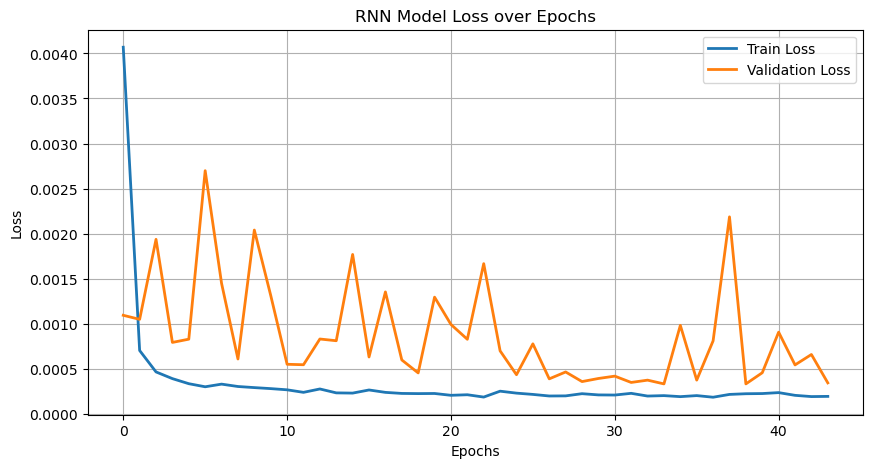

In [9]:
# Cell 9: Vẽ biểu đồ training/validation loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('RNN Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# Cell 10: Dự đoán trên tập test
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step  


In [11]:
# Cell 11: Tính các chỉ số MAE, MSE, RMSE, MAPE
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 1391.1026
MSE: 3520979.1639
RMSE: 1876.4272
MAPE: 2.04%


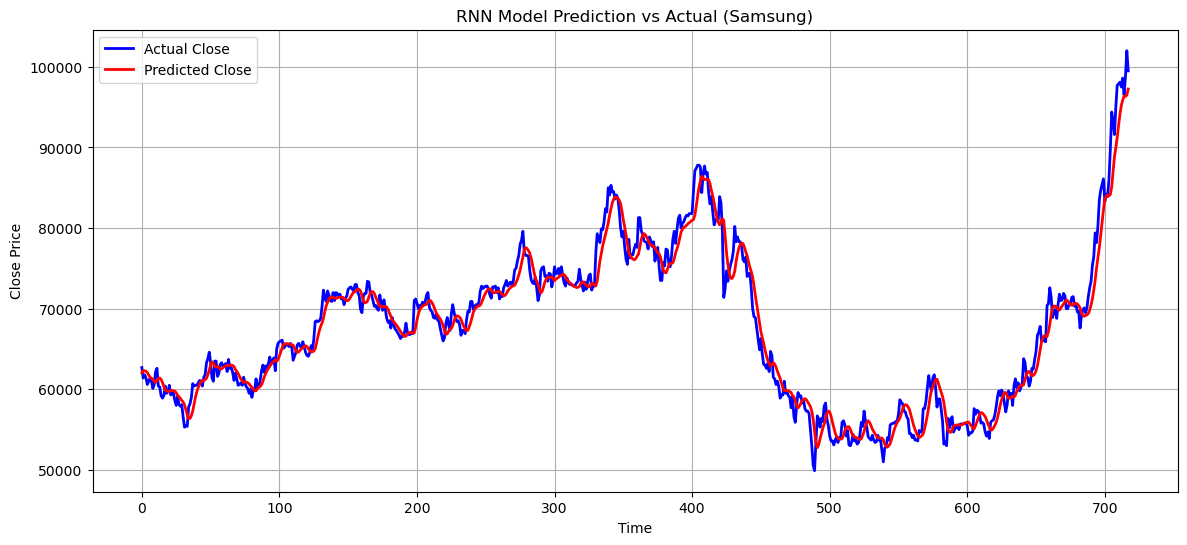

In [12]:
# Cell 12: Vẽ biểu đồ so sánh giá trị thực tế và dự đoán
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual Close', color='blue', linewidth=2)
plt.plot(y_pred_inv, label='Predicted Close', color='red', linewidth=2)
plt.title('RNN Model Prediction vs Actual (Samsung)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Cell 13: Dự đoán 30 ngày tiếp theo (fix chiều dữ liệu)
last_60_days = scaled_data[-60:]
pred_input = last_60_days.reshape(1, -1, 1)
future_predictions = []

for _ in range(30):
    pred = model.predict(pred_input)
    future_predictions.append(pred[0, 0])
    
    # Giữ lại 59 giá trị cuối cùng + giá trị dự đoán mới
    pred_input = np.append(pred_input[:, 1:, :], [[[pred[0, 0]]]], axis=1)

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions_inv = scaler.inverse_transform(future_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━

In [15]:
# Cell 14: Tạo index thời gian cho 30 ngày tiếp theo
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions_inv.flatten()
}).set_index('Date')

future_df.head()


,Predicted_Close
Date,
2025-10-30,98025.757812
2025-10-31,97847.851562
2025-11-01,97442.875000
2025-11-02,96930.132812
2025-11-03,96368.476562


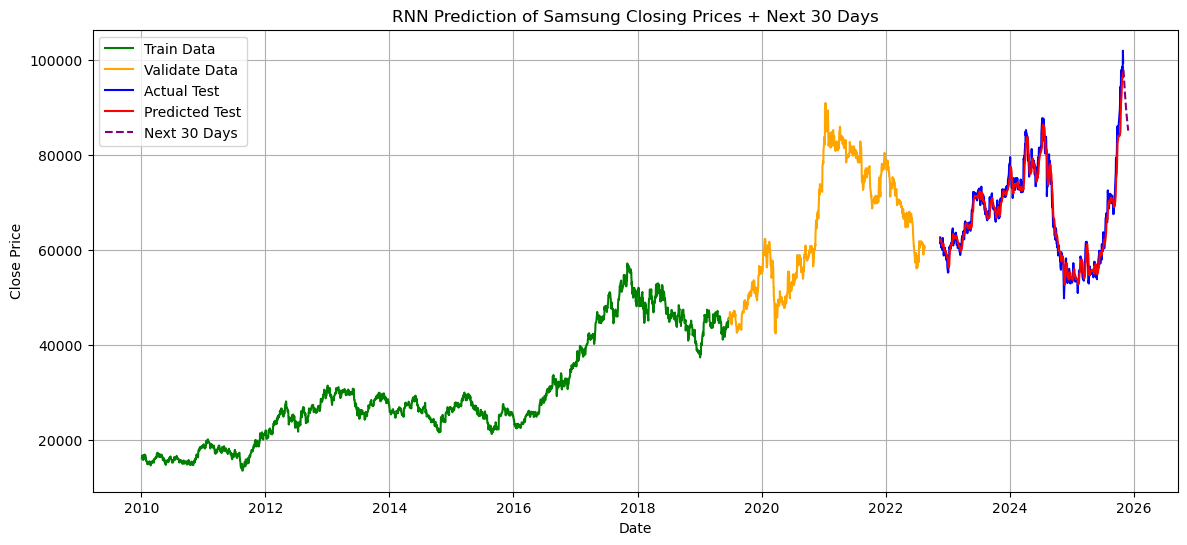

In [16]:
# Cell 15: Vẽ toàn bộ biểu đồ (Train, Test, Predict, Future)
train_plot = scaler.inverse_transform(train_data)
val_plot = scaler.inverse_transform(val_data)
test_plot = y_test_inv

plt.figure(figsize=(14,6))
plt.plot(df.index[:len(train_plot)], train_plot, label='Train Data', color='green')
plt.plot(df.index[len(train_plot):len(train_plot)+len(val_plot)], val_plot, label='Validate Data', color='orange')
plt.plot(df.index[-len(test_plot):], test_plot, label='Actual Test', color='blue')
plt.plot(df.index[-len(test_plot):], y_pred_inv, label='Predicted Test', color='red')
plt.plot(future_df.index, future_df['Predicted_Close'], label='Next 30 Days', color='purple', linestyle='--')
plt.title('RNN Prediction of Samsung Closing Prices + Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()
